In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from datetime import datetime
from itertools import combinations

In [2]:
entrenamiento = pd.read_csv("../Train_TP2_Datos_2020-2C.csv")
test_real     = pd.read_csv("../Test_TP2_Datos_2020-2C.csv")

In [3]:
#LIMPIEZA

entrenamiento = entrenamiento[( entrenamiento['Stage'] == 'Closed Won') | ( entrenamiento['Stage'] == 'Closed Lost')]

def limpiar(x):
    x = x.drop(columns=['ASP_(converted)_Currency','Quote_Type','Brand','Product_Type','Size','Product_Category_B','Price','Currency','Last_Activity','Actual_Delivery_Date','Prod_Category_A'])
    x = x.drop(columns=['Opportunity_Name','Sales_Contract_No'])
    return x

entrenamiento = limpiar(entrenamiento)
test_real = limpiar(test_real)

In [4]:
entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16883 entries, 0 to 16946
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  16883 non-null  int64  
 1   Region                              16883 non-null  object 
 2   Territory                           16883 non-null  object 
 3   Pricing, Delivery_Terms_Quote_Appr  16883 non-null  int64  
 4   Pricing, Delivery_Terms_Approved    16883 non-null  int64  
 5   Bureaucratic_Code_0_Approval        16883 non-null  int64  
 6   Bureaucratic_Code_0_Approved        16883 non-null  int64  
 7   Submitted_for_Approval              16883 non-null  int64  
 8   Bureaucratic_Code                   16883 non-null  object 
 9   Account_Created_Date                16883 non-null  object 
 10  Source                              16883 non-null  object 
 11  Billing_Country                     16883

In [5]:
#FECHA A DIAS

#Respalda fecha, usada para separa set_train y set_test
entrenamiento['Fecha'] = pd.to_datetime(entrenamiento['Opportunity_Created_Date'])

def fecha_a_dias(x):
    columnas_fecha = ['Month','Last_Modified_Date','Account_Created_Date','Opportunity_Created_Date','Quote_Expiry_Date','Planned_Delivery_Start_Date','Planned_Delivery_End_Date']
    for columna in columnas_fecha:
        x[columna] = pd.to_datetime(x[columna])
        x[columna] = x[columna].apply(lambda x : (x - pd.to_datetime('01/01/2000', format='%m/%d/%Y')).days)

fecha_a_dias(entrenamiento)
fecha_a_dias(test_real)

In [6]:
#QUITO STAGE
#objetivo = entrenamiento.pop('Stage')
#objetivo = objetivo.apply(lambda x : int(x == 'Closed Won'))
#objetivo

In [7]:
#CATEGORICAS A NUMERICAS  - TEMP
def categoricas_a_numericas(x):
    ohe = skl.preprocessing.OrdinalEncoder()
    columnas_object = list(x.select_dtypes(include=['object']).columns)
    if 'Stage' in columnas_object : columnas_object.remove('Stage')
    for columna in columnas_object:
        copia = x[[columna]].copy().dropna()
        df_temp = pd.DataFrame(ohe.fit_transform(copia)).astype('int32')
        df_temp.columns = [columna]
        x[columna] = df_temp[columna]

categoricas_a_numericas(entrenamiento)
categoricas_a_numericas(test_real)

In [8]:
#Nuevos Features

In [9]:
#Filtrado de columnas - No remover Stage o Fecha
#entrenamiento = entrenamiento[['Total_Amount_Currency']]

In [10]:
#Division entre set_datos y set_test

set_train = entrenamiento.loc[entrenamiento['Fecha'].dt.year == 2015]
set_test = entrenamiento.loc[entrenamiento['Fecha'].dt.year == 2016]
set_train_label = (set_train['Stage'] == 'Closed Won').astype(int)
set_test_label = (set_test['Stage'] == 'Closed Won').astype(int)

set_train = xgb.DMatrix(set_train.drop(columns=['Stage','Fecha']),label = set_train_label)
set_test  = xgb.DMatrix(set_test .drop(columns=['Stage','Fecha']),label = set_test_label)
evaluacion = [(set_test, 'eval'), (set_train, 'train')]

#entrenamiento = entrenamiento.drop(columns=['Fecha','Stage'])

[18:26:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.59196	train-logloss:0.52033
[1]	eval-logloss:0.52699	train-logloss:0.41659
[2]	eval-logloss:0.50975	train-logloss:0.35270
[3]	eval-logloss:0.48032	train-logloss:0.30691
[4]	eval-logloss:0.48633	train-logloss:0.27256


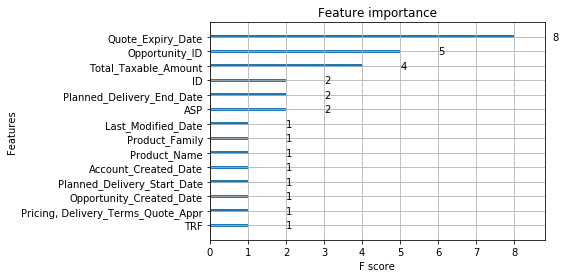

In [11]:
parametros = {"booster":"gbtree", "max_depth":3, "eta": 0.3, "objective": "binary:logistic", "nthread":2,"gamma" : 0}
rondas = 5

modelo = xgb.train(parametros, set_train, rondas, evaluacion)

xgb.plot_importance(modelo)
plt.show()

In [12]:
prediccion = modelo.predict(set_test)

prediccion = [1 if i > .5 else 0 for i in prediccion]

def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

metrics = metricas(set_test_label, prediccion)
print("Prediccion Test")
[print(i) for i in metrics]
print(skl.metrics.log_loss(set_test_label,prediccion))

prediccion = modelo.predict(set_train)
prediccion = [1 if i > .5 else 0 for i in prediccion]
metricas = metricas(set_train_label, prediccion)
print("Prediccion Train")
[print(i) for i in metricas]

Prediccion Test
[[2146  111]
 [1081 1017]]
0.7262916188289322
              precision    recall  f1-score   support

           0       0.67      0.95      0.78      2257
           1       0.90      0.48      0.63      2098

    accuracy                           0.73      4355
   macro avg       0.78      0.72      0.71      4355
weighted avg       0.78      0.73      0.71      4355

9.453572954775725
Prediccion Train
[[713  23]
 [ 69 207]]
0.9090909090909091
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       736
           1       0.90      0.75      0.82       276

    accuracy                           0.91      1012
   macro avg       0.91      0.86      0.88      1012
weighted avg       0.91      0.91      0.91      1012



[None, None, None]